In [1]:
import skimage as ski
from skimage import data as skidata
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy as sci
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import (
    exposure, util
)

[[200 200 200 ... 189 190 190]
 [200 199 199 ... 190 190 190]
 [199 199 199 ... 190 190 190]
 ...
 [ 25  25  27 ... 139 122 147]
 [ 25  25  26 ... 158 141 168]
 [ 25  25  27 ... 151 152 149]]


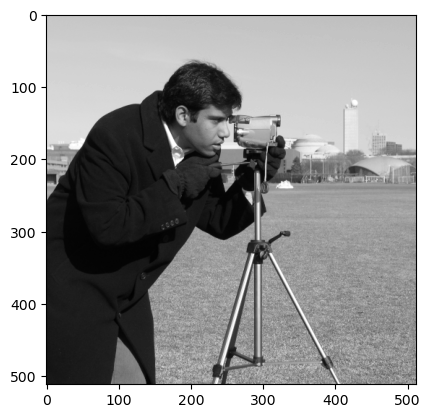

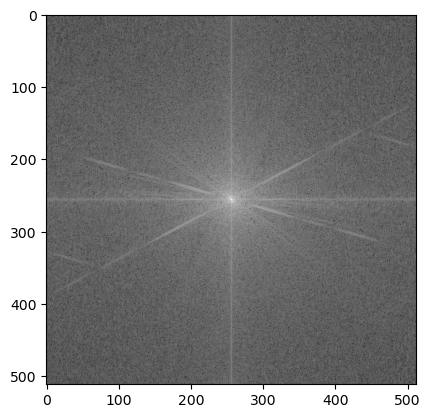

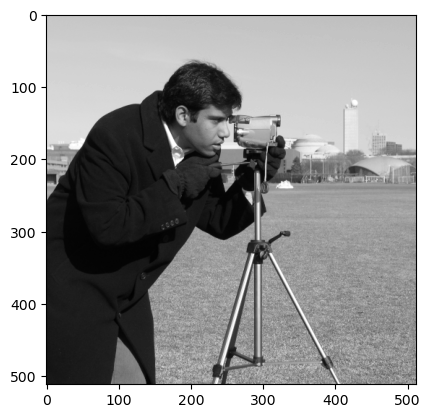

256.0


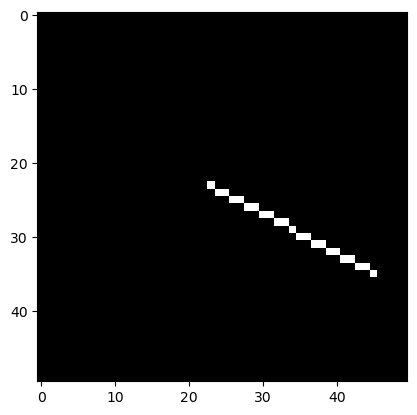

'compress_im = camera_man*(mask/np.sum(mask))\n\nprint(np.max(compress_im),np.min(compress_im))\nplt.imshow(compress_im,cmap=plt.cm.gray)\nplt.show()'

In [2]:
## import image
camera_man=getattr(skidata,"camera")()

plt.imshow(camera_man,cmap=plt.cm.gray)
plt.gcf().savefig("cameraman.png",dpi=400)
plt.show()
#create compressed image
fft_camera = np.fft.fft2(camera_man)
fin_fft = np.fft.fftshift(fft_camera)
fourier_im = 20*np.log(np.abs(fin_fft)) 
plt.imshow(fourier_im,cmap=plt.cm.gray)
plt.gcf().savefig("ftcameraman.png",dpi=400)
plt.show()
#inverse fourier of image
inv = np.fft.ifft2(fin_fft)
plt.imshow((np.abs(inv)),cmap=plt.cm.gray)
plt.show()
##draw a circle and take the insides of the fft camera
mask = np.zeros((50,50), dtype=np.uint8)
print(camera_man.shape[0]/2)
rr, cc = ski.draw.line(int(mask.shape[0]/2)-2,int(mask.shape[1]/2)-2 ,int(mask.shape[1]/2)+10,int(mask.shape[1]/2)+20)
mask[rr, cc] = 1
plt.imshow(mask,cmap=plt.cm.gray)
plt.show()




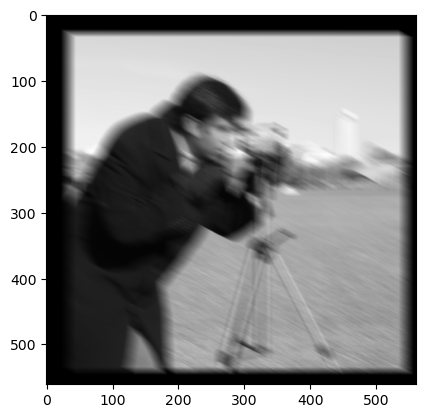

In [3]:
blur_im=sci.signal.convolve2d(camera_man,mask/np.sum(mask))
plt.imshow(blur_im,cmap="gray")
plt.show()

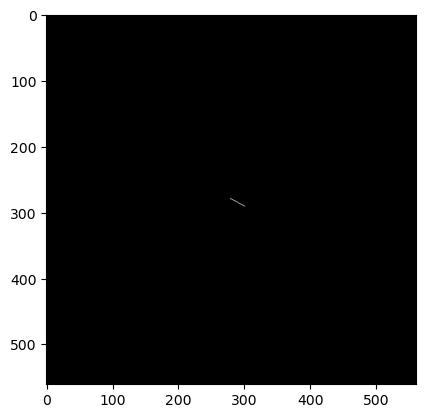

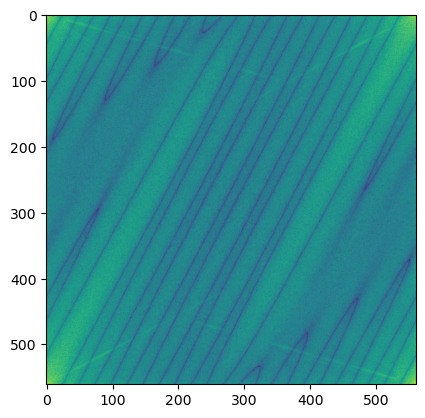

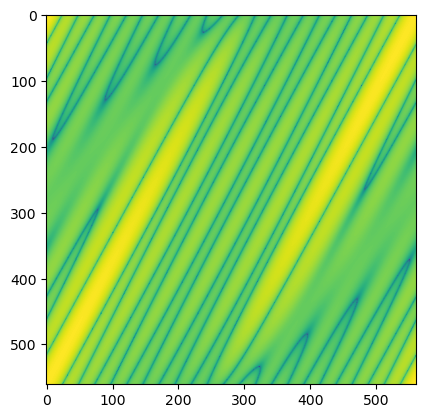

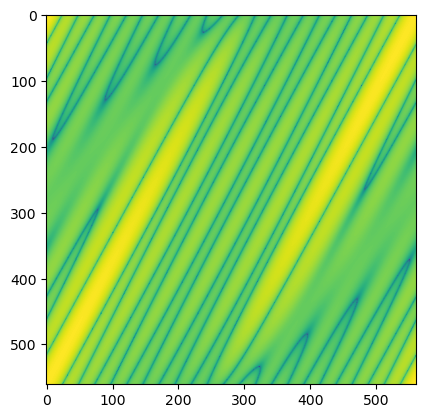

In [4]:
#inverse fourier of the compressed image

ft_blur_im = np.fft.fft2(blur_im)
#ft_blur_im = np.fft.fftshift(ft_blur_im)
second_mask = np.pad(mask,(256,255),mode="constant",constant_values=(0,0))
plt.imshow(second_mask,cmap="gray")
plt.gcf().savefig("psf.png",dpi=400)
plt.show()
ft_mask = np.fft.fft2(second_mask/np.sum(second_mask))
#ft_mask = np.fft.fftshift(ft_mask)
plt.imshow(np.log(np.abs(ft_blur_im)))
plt.show()
plt.imshow(np.log(np.abs(ft_mask)))
plt.show()
ft_second_mask = np.fft.fft2(second_mask/np.sum(mask))
plt.imshow(np.log(np.abs(ft_second_mask)))
plt.show()

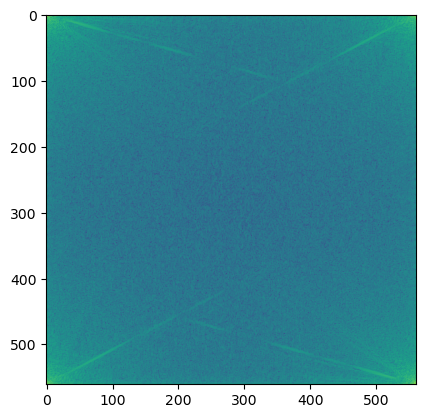

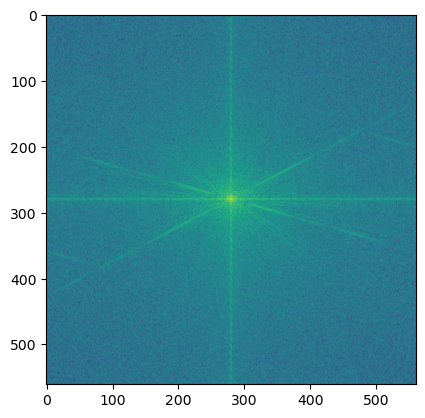

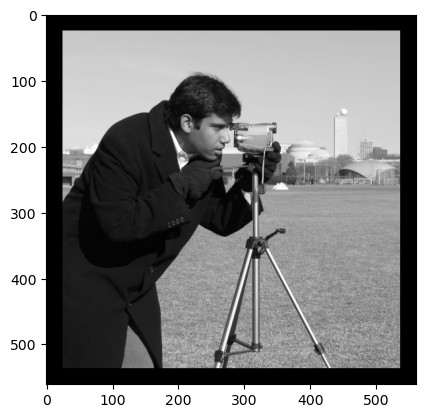

In [5]:
#imply lasso to reduce the mask's pixels 
ft_recons = np.divide(ft_blur_im,ft_second_mask)


plt.imshow(np.log(np.abs(np.fft.fftshift(ft_recons))))
plt.show()
recons=np.fft.ifft2(np.fft.fftshift(ft_recons))
plt.imshow(np.abs((np.fft.ifftshift(recons))),cmap="gray")
plt.show()

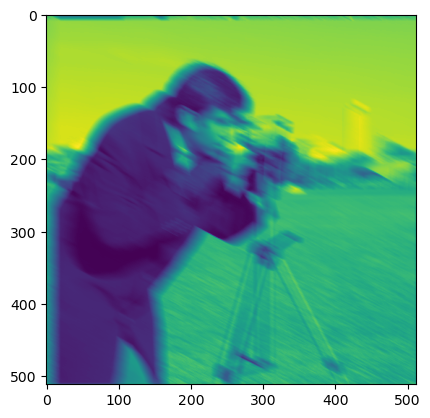

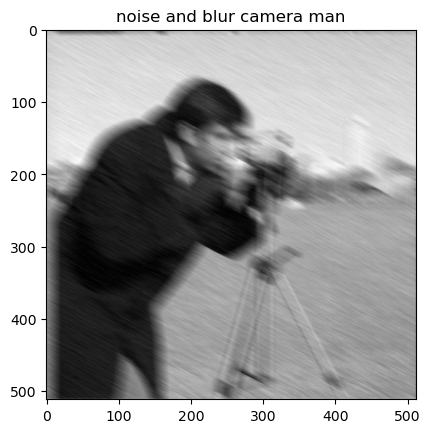

SNR: 74851.86619000249 19.97996268502989 8.228536416332588


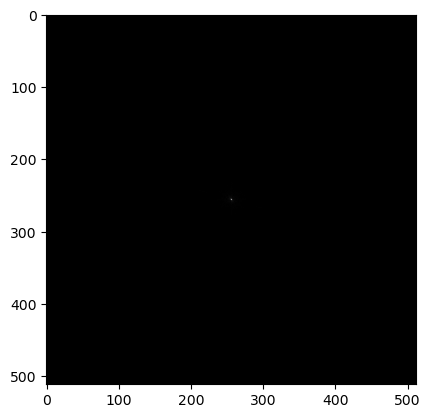

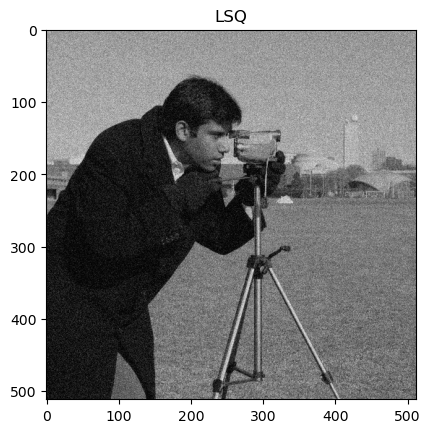

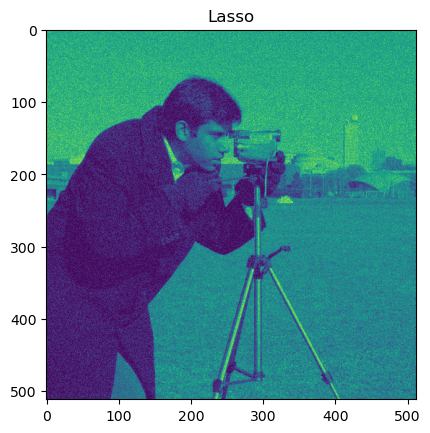

MSE LSQ:  97773122.68774478 MSE_Lasso:  97759907.43639928
Lasso is better


In [10]:
#I will give fista to my psf and blurred image and expect to get deblurred signal
#first try to write a function in a cost effective way to calculate convolution
second_mask = np.pad(mask,(231,231),mode="constant",constant_values=(0,0))
ft1_cam_man =np.fft.fftshift(np.fft.fft2(camera_man))
ft1_mask = np.fft.fftshift(np.fft.fft2(second_mask/np.sum(second_mask)))
ft1_blur = ft1_cam_man*ft1_mask
ift1_blur=np.fft.ifftshift(np.fft.ifft2(ft1_cam_man*ft1_mask))

#I want to take my psf as a sparsed matrix and try to deconvolve with my blurred image
#add noise to your picture
noise_level=20
noise = noise_level*np.random.randn(camera_man.shape[0],camera_man.shape[1])
noise2=noise_level*np.random.randn(blur_im.shape[0],blur_im.shape[1])

noised_camera_man = camera_man + noise

ft1_noise_cam_man =np.fft.fftshift(np.fft.fft2(noised_camera_man))
ft1_noise_blur = ft1_noise_cam_man*ft1_mask
ift1_noise_blur = np.fft.ifftshift(np.fft.ifft2(ft1_noise_blur))
plt.imshow(np.abs(ift1_noise_blur),cmap="gray")
plt.title("noise and blur camera man")
plt.gcf().savefig("noisyblurredcameraman.png",dpi=400)
plt.show()
print("SNR:",np.std(ft1_noise_blur),np.std(noise),np.log(np.std(ft1_noise_blur)/np.abs(np.std(noise))))
#LSQ
new_mat = np.divide((ft1_mask.conj().T*ft1_noise_blur),(ft1_mask.conj().T*ft1_mask+1e-10))
plt.imshow(np.abs(new_mat),cmap="gray")
#plt.gcf().savefig("lsqres.png")
plt.show()

ft1_new_mat = (np.fft.ifft2(new_mat))
plt.imshow(np.abs(ft1_new_mat),cmap="gray")
plt.title("LSQ")
plt.gcf().savefig("lsqres.png")
plt.show()
#LASSO
lamd=1
iteration = 100
sol=np.divide((ft1_mask.conj().T*ft1_noise_blur),(ft1_mask.conj().T*ft1_mask+1e-10))

for ix in range(iteration):
    gamma=1/(np.sqrt(np.abs(sol))+1e-10)
    gamma_mat = gamma.conj().T*gamma
    sol_new = np.divide((ft1_mask.conj().T*ft1_noise_blur),(ft1_mask.conj().T*ft1_mask+np.eye(camera_man.shape[0])*lamd*gamma_mat))
    sol=sol_new
ft1_sol = np.fft.ifft2(sol)
plt.imshow(np.abs(ft1_sol),cmap="gray")
plt.title("Lasso")
plt.gcf().savefig("lassores.png")
plt.show()


MSE_LSQ = np.sum((camera_man-np.abs(ft1_new_mat))**2)
MSE_Lasso = np.sum((camera_man-np.abs(ft1_sol))**2)
print("MSE LSQ: ",str(MSE_LSQ),"MSE_Lasso: ",str(MSE_Lasso))
if MSE_LSQ>MSE_Lasso:
    print("Lasso is better")